In [1]:
import pandas as pd
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Tuple, Dict, List, Any, Union, TypeVar, TypedDict
import warnings
warnings.filterwarnings("ignore")
# we need this here.
# otherwise there's going to be a buttload of 'UserWarning: n_quantiles(1000) is greater than the total number'
# messages everywhere, which are kinda annoying.

%matplotlib inline

### Part A

In [2]:
# HERE YOU WILL WRITE CODE TO TEST A NUMBER OF PREDICTORS
# AND FINALLY CHOOSE AND TRAIN THE PREDICTOR THAT YOU WILL BE USING FOR PART B

# To the owners of the hotel: your choice of omitting meaningful feature labels is incredibly unhelpful.

# Attempting to decipher the provided data, along with the utterly unhelpful lack of named features given

I would appreciate it if you were to provide me with actual feature names for your dataset
instead of merely 'F1, F2, F3...', as, with the feature names given, it would cut down on any
unnecessary time-wasting 'deciphering which feature is which'. This would be mutually beneficial,
as it would allow me to easily work out how to best normalize values for each feature,
discuss any relevant information gained by each feature, and, when the final model is being demonstrated,
it will be easier for you to understand what the model is doing, as you won't have to remember what
F1, F2, F3... actually are supposed to mean.

Furthermore, it indicates an unwillingness to work cooperatively with me,
and I fear that this lack of a constructive working relationship may result in
similarly non-ideal outcomes for both of us.

In [3]:
all_data: pd.DataFrame = pd.read_csv("CE802_P2_Data.csv")
all_data.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F13,F14,F15,F16,F17,F18,F19,F20,F21,Class
0,3.8490,2.9620,-190.500,3163.97,14.448000,1775.070,1,7410.604,-13415.52,0,...,24.821,14.1740,7.4220,-1381.62,6.93780,3600.24,775.900,1.9011,NaN,True
1,3.6792,4.7180,-177.570,1163.87,11.027628,1179.270,0,7422.872,-14671.92,1,...,21.782,10.9442,6.8502,-1318.12,6.56130,3523.04,804.980,2.2173,NaN,False
2,4.3035,2.4680,-193.920,1155.93,15.231000,1343.670,1,7259.700,-12901.92,1,...,12.284,10.2526,9.3520,-1318.32,5.32809,4573.64,865.670,1.3770,-9.38,True
3,6.5220,8.6280,-166.548,1281.57,11.011309,877.932,1,7397.640,-11732.82,0,...,13.075,9.8132,6.5904,-1579.72,10.69800,3343.95,723.427,4.7820,NaN,False
4,7.6500,1.0264,-197.540,954.77,11.521500,636.870,1,9476.220,-11194.44,0,...,25.762,9.3566,6.9936,-768.72,6.14040,3708.24,47.070,2.6286,-11.32,True


In [4]:
all_data.dtypes

F1       float64
F2       float64
F3       float64
F4       float64
F5       float64
F6       float64
F7         int64
F8       float64
F9       float64
F10        int64
F11      float64
F12      float64
F13      float64
F14      float64
F15      float64
F16      float64
F17      float64
F18      float64
F19      float64
F20      float64
F21      float64
Class       bool
dtype: object

## Attempting to get an overview of the data ranges etc of the features, and seeing if there's any obvious correlations between them and the labels

Once again, proper label names would have been useful here, but noooooooooooooo,
you didn't give me any.

In [5]:
_all_data_inputs = all_data.loc[:, all_data.columns != 'Class'].to_numpy()
_all_data_classes = all_data.loc[:, 'Class'].to_numpy()
print(_all_data_inputs.shape, _all_data_classes.shape)


(1000, 21) (1000,)


In [6]:
def np_data_and_classes(df: pd.DataFrame, classname: str = "Class") -> Tuple[np.ndarray, np.ndarray]:
    """
    Converts dataframe into a couple of numpy ndarrays for the data without the labels, and the labels by themselves
    :param df: the Dataframe
    :param classname: The name of the column holding the classes
    :return: tuple of [ndarray of the values without the class labels, just the class labels]
    """

    inputs:  np.ndarray = df.loc[:,df.columns != classname].to_numpy()

    if inputs.shape == df.shape:
        inputs: np.ndarray = df.loc[:,:-1].to_numpy()
        outs: np.ndarray = df.loc[:,-1].to_numpy()
        return inputs, outs

    outputs: np.ndarray = df.loc[:,classname].to_numpy()

    return inputs, outputs


In [7]:


def show_all_data_inputs_labels(inputs_np: np.ndarray, labels_np: np.ndarray, all_columns, rows = 3, row_height=2, wh_ratio = 4/3) -> plt.Figure:
    total_cols = inputs_np.shape[1]
    cols = math.ceil(total_cols/rows)
    newplot: plt.Figure = plt.figure(figsize=(math.ceil(cols * row_height * wh_ratio), rows * row_height))

    for i in range(total_cols):
        ax: plt.Axes = newplot.add_subplot(rows, cols, i+1)
        ax.scatter(labels_np, inputs_np[:,i])
        ax.set_xticks([0,1])
        ax.set_title(all_columns[i])

    return newplot


''

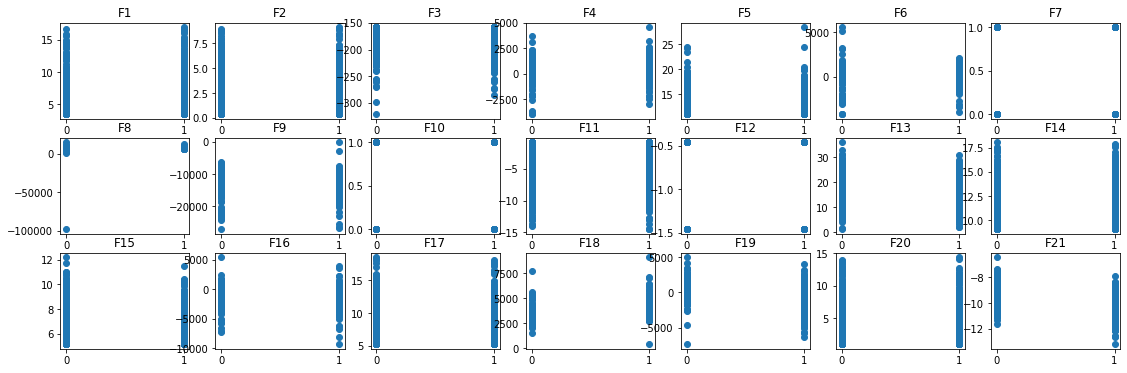

In [8]:
show_all_data_inputs_labels(_all_data_inputs, _all_data_classes, all_data.columns)

""

## Attempting to show all of the data as curves, for ease of visualization

Those previous graphs, despite giving a basic overview of the ranges of
the data for profitable/non-profitable establishments, don't give a
decent view of the overall range of the data for the full dataset.

So I've taken the liberty of reorganizing the displayed data to show it
as a series of curves instead, for the full dataset (top 3 rows),
the profitable establishments (middle 3 rows), and then for the
loss-making establishments (bottom 3 rows). This is so I can get a
clearer view of the actual useful values (instead of having them all bunched up together),
because, as you can probably appreciate, it's difficult to get a nice overview of
the ranges/distributions of values from just looking at a .csv


In [9]:
def show_all_data_curves(inputs_np: np.ndarray, labels_np: np.ndarray, all_columns, sorting = True, rows = 3, row_height=2, wh_ratio = 4/3, show_all_details = True) -> plt.Figure:
    t_data: np.ndarray = inputs_np[labels_np]
    f_data: np.ndarray = inputs_np[~labels_np]

    total_cols = inputs_np.shape[1]
    cols = math.ceil(total_cols/rows)

    actual_rows = rows * (3 if show_all_details else 1)

    newplot: plt.Figure = plt.figure(figsize=(math.ceil(cols * row_height * wh_ratio), actual_rows * row_height))

    for i in range(total_cols):
        ax: plt.Axes = newplot.add_subplot(actual_rows, cols, i+1)
        this_sort: np.ndarray = np.sort(inputs_np[:,i]) if sorting else inputs_np[:,i]
        ax.scatter([i for i in range(len(this_sort))], this_sort)
        ax.set_xticks([])
        ax.set_title(all_columns[i] + " All")

    if show_all_details:
        for i in range(total_cols):
            ax: plt.Axes = newplot.add_subplot(actual_rows, cols, i+1 + total_cols)
            this_sort: np.ndarray = np.sort(t_data[:,i]) if sorting else t_data[:,i]
            ax.scatter([i for i in range(len(this_sort))], this_sort)
            ax.set_xticks([])
            ax.set_title(all_columns[i] + " true")

        for i in range(total_cols):
            ax: plt.Axes = newplot.add_subplot(actual_rows, cols, i+1 + (total_cols * 2))
            this_sort: np.ndarray = np.sort(f_data[:,i]) if sorting else f_data[:,i]
            ax.scatter([i for i in range(len(this_sort))], this_sort)
            ax.set_xticks([])
            ax.set_title(all_columns[i] + " false")

    return newplot

''

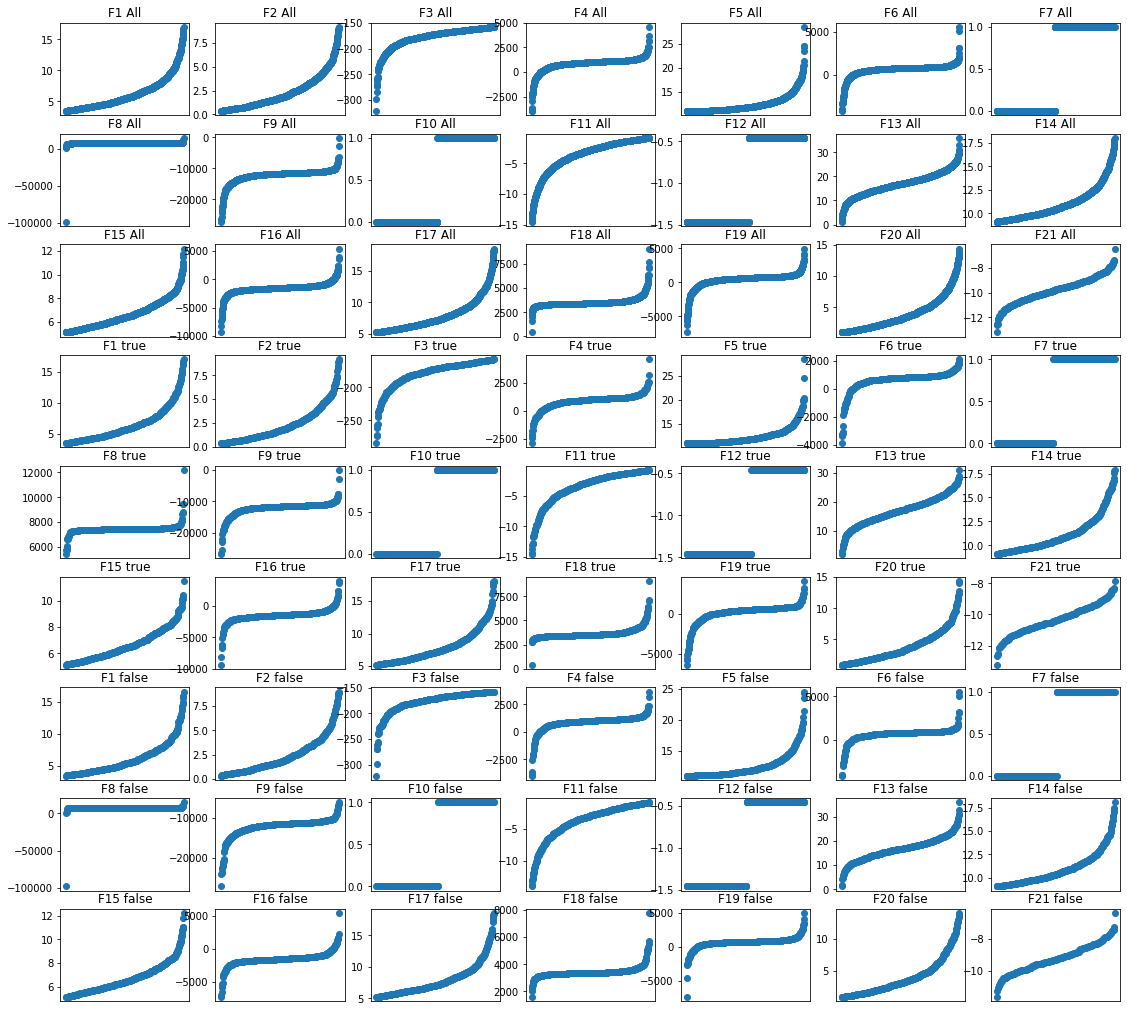

In [10]:
show_all_data_curves(_all_data_inputs, _all_data_classes, all_data.columns).show()
""

#### Attempting to perform some normalization on the data, despite your lack of labels for the data

Here is a quick test of some gaussian normalization,
to get every datapoint into a manageable range. Which, for this particular situation,
appears to be a range between -5 and 5. Sure, it's not the obvious range of (-1, 1),
but at the end of the day, it's still a fixed range, so I'll take it.

This is effectively a sanity check, **NOT THE FINAL NORMALIZATION**,
because each fold within the K-Fold Cross Validation will need to fit their own
normalization stuff to the training data provided within that fold.

Now, you might be wondering '*wait, why are you applying gaussian normalization to everything?*
*some of this data is about info like money or is already appropriately scaled, meaning that there's*
*no reason to apply this normalization to it!*'. If you do wish to raise such concerns,
and wish for them to be taken seriously, such concerns would be best raised accompanied
by actual feature names for these features. After all, when I have no information I can use
to make a judgement about what does and does not need normalization, I will have to err
on the side of caution, and assume that all of them do need normalization.
And doing gaussian normalization ensures that any outliers can be marked as outliers, whilst
allowing anything that isn't an outlier to have a value which is appropriately near to the
other non-outlier values.

Of course, in the below graphs, every single value for each attribute is shown on the x axis
in order of their size on the y axis, so they are visible as very nice-looking curves. In reality,
these graphs do not look anywhere near as neat as this, so

''

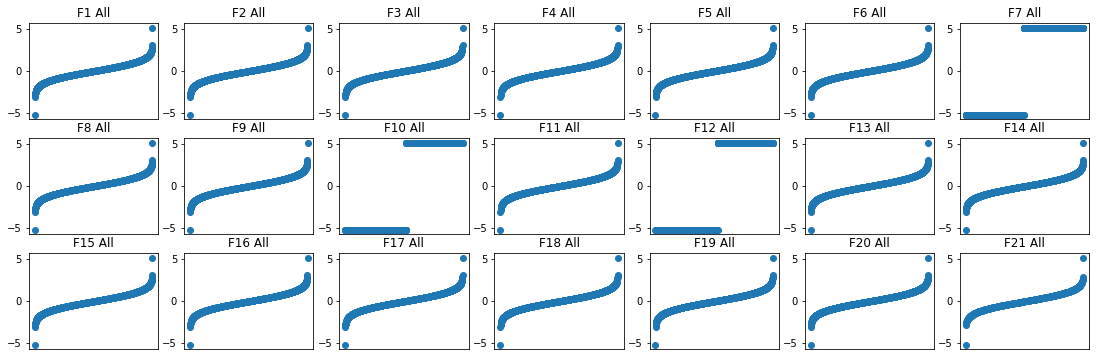

In [11]:
from sklearn.preprocessing import QuantileTransformer
_qt: QuantileTransformer = QuantileTransformer(output_distribution="normal")

_transform_inputs: np.ndarray = _qt.fit_transform(_all_data_inputs)

show_all_data_curves(_transform_inputs, _all_data_classes, all_data.columns, show_all_details=False).show()
""

Now those are some nice-looking normalized curves, which will promptly be disposed of,
and never touched again.

However, when I'm doing the K-fold stuff, the individual training data subsets will be
normalized into these sorts of curves. And this should help you at least visualize that.


# Obtaining a validation set

In this code cell, I am splitting the given data into a validation set of 200 indices,
and a training set of 800 indices.

The training set will be used in the actual k-fold stuff.

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, GridSearchCV

validation_cv: StratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True)

all_train_indices, validation_indices = [i for i in validation_cv.split(_all_data_inputs, _all_data_classes)][0]

validation_df: pd.DataFrame = all_data.iloc[validation_indices]
tests: Tuple[np.ndarray, np.ndarray] = np_data_and_classes(validation_df)
test_data: np.ndarray = tests[0]
test_labels: np.ndarray = tests[1]

train_df: pd.DataFrame = all_data.iloc[all_train_indices]
trains: Tuple[np.ndarray, np.ndarray] = np_data_and_classes(train_df)
train_data: np.ndarray = trains[0]
train_labels: np.ndarray = trains[1]


print("validation")
print(validation_df.head())
print(validation_df.shape)
print("train")
print(train_df.head())
print(train_df.shape)


validation
        F1      F2       F3       F4         F5       F6  F7        F8  \
2   4.3035  2.4680 -193.920  1155.93  15.231000  1343.67   1  7259.700   
4   7.6500  1.0264 -197.540   954.77  11.521500   636.87   1  9476.220   
5   7.6260  3.3380 -171.954  1213.87  11.022816  1658.37   1  7435.778   
13  4.7748  1.6714 -181.280  1251.67  12.420900   827.13   0  7413.790   
14  9.0630  2.1978 -167.866   593.17  11.041200   451.77   0  7534.260   

          F9  F10  ...     F13       F14      F15      F16      F17      F18  \
2  -12901.92    1  ...  12.284  10.25260  9.35200 -1318.32  5.32809  4573.64   
4  -11194.44    0  ...  25.762   9.35660  6.99360  -768.72  6.14040  3708.24   
5  -11439.81    0  ...  12.868   9.15954  5.30954  1031.48  7.60020  3575.44   
13 -12978.42    1  ...  18.786  11.85600  5.67600 -1680.88  5.35020  3091.14   
14 -11171.01    0  ...  20.413   9.38060  8.37000  -440.92  5.21856  6350.64   

       F19     F20    F21  Class  
2   865.67  1.3770  -9.38   

In [13]:

from sklearn.base import ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.metrics import balanced_accuracy_score, make_scorer, accuracy_score, precision_score, recall_score, average_precision_score, precision_recall_curve
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

set_config(display="diagram")

C = TypeVar('C', bound=ClassifierMixin)

### Some functions for Grid-Search Nested Cross Validation

And time for me to write most of the code I'll be using later on.
These functions handle some nested cross-validation, both to work out an optimal
hyper-parameter configuration for the different model types, and to also, y'know,
train them (with nested cross-validation!).

The models I am using are actually, strictly speaking, pipelines.

First, as mentioned earlier, there's going to be some scaling on the values of the data.
It will be turned into a gaussian curve, based on the distributions etc of the
given training data.

Then, missing values will be imputed via KNN-imputation, working on the theory that
if the rest of the individual data thingy is similar to the values in other thingies,
that missing value is likely to be somewhat similar to those values in the other
similar ones. It's a bit more elegant than just disposing of the data entirely
due to incomplete data being provided. This KNN-imputation happens *after* the data
is scaled, because it's probably a bit less messy to compare similarities between
individuals and also impute the data from that whilst they're scaled than whilst they're
not scaled.

Finally, it'll be given to the actual classifier, that's being used to do the rather important
job of predicting whether or not a given establishment is going to be profitable or not.


I'm using HalvingGridSearchCV here, instead of the traditional GridSearchCV.
This is mostly in the interests of time. Whilst it doesn't support multiple scoring metrics
(unlike the normal GridSearchCV), it *does* support doing the grid search cross validation
in a fraction of the time. Which, as far as my sanity is concerned, is a good thing!

In [14]:
def h_grid_searcher(
    classifier: C,
    param_grid: Dict[str, List[Any]],
    train_data: np.ndarray,
    train_labels: np.ndarray,
    strat_k_fold: StratifiedKFold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
) -> HalvingGridSearchCV:
    """
    This attempts to perform a single Halving-Grid Search Cross Validation,
    using classifier C, with the given parameter grid, and also using  the specified
    training data and training labels, with a specific StratifiedKFold instance.

    :param classifier: the type of classifier we're using
    :param param_grid: the parameter_grid being used
    :param train_data: the training data being used
    :param train_labels: the labels for the aforementioned training data
    :param strat_k_fold: the stratified K-Fold instance being used
    :return: a fitted HalvingGridSearchCV, based on specificity/precision score,
     given these arguments
    """

    param_grid["imputer__weights"] = ["distance","uniform"]

    pl: Pipeline = Pipeline([
        ("scaler", QuantileTransformer(output_distribution="normal")),
        ("imputer", KNNImputer(add_indicator=True)),
        ("classifier", classifier)
    ])

    h_grid_search: HalvingGridSearchCV = HalvingGridSearchCV(
        estimator=pl,
        param_grid=param_grid,
        factor=3,
        cv=strat_k_fold,
        # We're doing scoring based on specificity/precision score, as previously mentioned.
        scoring=make_scorer(average_precision_score),
        refit=True,
        verbose=1,
        n_jobs=-1,
        error_score=0 # if there's an oopsie, we give this a score of 0.
    )

    h_grid_search.fit(train_data, train_labels)


    return h_grid_search


In [15]:

def nested_h_grid_searcher(
    classifier: C,
    param_grid: Dict[str, List[Any]],
    train_data: np.ndarray,
    train_labels: np.ndarray,
    t_df: pd.DataFrame,
    kfold_splits: int = 4
) -> Dict[HalvingGridSearchCV, Tuple[float, np.ndarray, np.ndarray]]:
    """
    Attempts to perform a HalvingGridSearchCV, with nested cross-validation
    :param classifier: the type of classifier we're attempting to use
    :param param_grid: the param_grid we're attempting to use for the classifierMixin
    :param train_data: ndarray of training data with the labels removed
    :param train_labels: ndarray of the labels of the training data
    :param t_df: A dataframe holding all of the training data
    :param kfold_splits: how many kfold splits are being used
    :return: a dictionary of HalvingGridSearchCV -> (score on test subset, test subset data, test subset labels)
    """


    h_grids_d: Dict[HalvingGridSearchCV, Tuple[float, np.ndarray, np.ndarray]] = {}

    skf: StratifiedKFold = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

    for train_indices, test_indices in skf.split(train_data, train_labels):

        tr: Tuple[np.ndarray, np.ndarray] = np_data_and_classes(t_df.iloc[train_indices])
        te: Tuple[np.ndarray, np.ndarray] = np_data_and_classes(t_df.iloc[test_indices])


        current_search: HalvingGridSearchCV = h_grid_searcher(
            classifier,
            param_grid,
            tr[0],
            tr[1],
            StratifiedKFold(n_splits=kfold_splits-1, shuffle=False)
        )


        current_score: float = current_search.score(te[0],te[1])

        #h_grids[current_search] = current_score

        h_grids_d[current_search] = (current_score, te[0],te[1])

    return h_grids_d


class BestGridSearchDict(TypedDict):
    search: HalvingGridSearchCV
    score: float
    test_data: np.ndarray
    train_data: np.ndarray


In [16]:
from sklearn.tree import DecisionTreeClassifier


# Decision Trees

I *could* just create a decision tree, with whatever configuration of hyper-parameters I want,
in this section of the notebook. But instead, I am going to try to generate a decision tree
with the best possible configuration of hyper-parameters possible. This is intended to
make sure that the final result will be, on the whole, not entirely terrible.

I am also going to take care of the problem of overfitting via the medium of the hyper-parameter
cross-validation grid search functionality of Scikit-Learn. Specifically, I will perform some
implicit pre-pruning by taking advantage of the 'min_impurity_decrease' hyperparameter of the
decision tree (this prevents splits that don't lead to a significant enough decrease in
the impurity of the leaf nodes), along with the 'min_samples_split' hyperparameter (if
there are fewer samples than specified by this variable, no spliting will occur).
Implicit post-pruning will be performed via the 'ccp_alpha' hyperparameter of the
decision tree (removing any subtrees which have a complexity falling below this value).

Of course, if the end result of this shows a complete lack of pruning, despite the nested
cross-validation used to obtain the result, I shall have to take this as a sign that
the lack of pruning is the optimal approach, as the cross validation would, in theory,
have significantly penalized overfit models in comparison to less overfit models.


In [17]:
tree_crits: List[str] = ["gini","entropy"]
tree_splits: List[str] = ["best","random"]
tree_alpha: List[float] = [0, *np.geomspace(0.00001,0.2,6)[1:]]
tree_max_features: List[Union[str,None, int]] = [None,"sqrt","log2",1,2]
tree_min_split: List[int] = [2,4,6,8]
tree_min_impurity_split: List[float] = [0, *np.geomspace(0.00001,0.2,6)[1:]]

tree_param_grid: Dict[str, List[Any]] = {
    "classifier__criterion": tree_crits,
    "classifier__splitter": tree_splits,
    "classifier__ccp_alpha": tree_alpha,
    "classifier__max_features": tree_max_features,
    "classifier__min_samples_split": tree_min_split,
    "classifier__min_impurity_decrease": tree_min_impurity_split
}

trees_searched_dict: Dict[
    HalvingGridSearchCV, Tuple[float, np.ndarray, np.ndarray]
] = nested_h_grid_searcher(
    DecisionTreeClassifier(),
    tree_param_grid,
    train_data,
    train_labels,
    train_df
)

tree_searched: HalvingGridSearchCV = max(
    trees_searched_dict.keys(), key=lambda k: trees_searched_dict[k][0]
)

best_tree_search: BestGridSearchDict = {
    "search": tree_searched,
    "score": trees_searched_dict[tree_searched][0],
    "test_data": trees_searched_dict[tree_searched][1],
    "train_data": trees_searched_dict[tree_searched][2]
}

n_iterations: 4
n_required_iterations: 8
n_possible_iterations: 4
min_resources_: 12
max_resources_: 600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 5760
n_resources: 12
Fitting 3 folds for each of 5760 candidates, totalling 17280 fits
----------
iter: 1
n_candidates: 1920
n_resources: 36
Fitting 3 folds for each of 1920 candidates, totalling 5760 fits
----------
iter: 2
n_candidates: 640
n_resources: 108
Fitting 3 folds for each of 640 candidates, totalling 1920 fits
----------
iter: 3
n_candidates: 214
n_resources: 324
Fitting 3 folds for each of 214 candidates, totalling 642 fits
n_iterations: 4
n_required_iterations: 8
n_possible_iterations: 4
min_resources_: 12
max_resources_: 600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 5760
n_resources: 12
Fitting 3 folds for each of 5760 candidates, totalling 17280 fits
----------
iter: 1
n_candidates: 1920
n_resources: 36
Fitting 3 folds for each of 1920 candidates, totalling 5760 fi

In [18]:
print(best_tree_search)


{'search': HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    error_score=0,
                    estimator=Pipeline(steps=[('scaler',
                                               QuantileTransformer(output_distribution='normal')),
                                              ('imputer',
                                               KNNImputer(add_indicator=True)),
                                              ('classifier',
                                               DecisionTreeClassifier())]),
                    n_jobs=-1,
                    param_grid={'classifier__ccp_alpha': [0,
                                                          7.247796636776961e-05,
                                                          0.00052530...
                                'classifier__min_impurity_decrease': [0,
                                                                      7.247796636776961e-05,
                          

In [19]:
print(best_tree_search["score"])
print(tree_searched.best_params_)

tree_searched.best_estimator_


0.8299249770337858
{'classifier__ccp_alpha': 7.247796636776961e-05, 'classifier__criterion': 'gini', 'classifier__max_features': None, 'classifier__min_impurity_decrease': 0, 'classifier__min_samples_split': 8, 'classifier__splitter': 'best', 'imputer__weights': 'distance'}


Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(add_indicator=True, weights='distance')),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=7.247796636776961e-05,
                                        min_impurity_decrease=0,
                                        min_samples_split=8))])

In [20]:
print(tree_searched)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    error_score=0,
                    estimator=Pipeline(steps=[('scaler',
                                               QuantileTransformer(output_distribution='normal')),
                                              ('imputer',
                                               KNNImputer(add_indicator=True)),
                                              ('classifier',
                                               DecisionTreeClassifier())]),
                    n_jobs=-1,
                    param_grid={'classifier__ccp_alpha': [0,
                                                          7.247796636776961e-05,
                                                          0.00052530...
                                'classifier__min_impurity_decrease': [0,
                                                                      7.247796636776961e-05,
                                     

In [21]:
tree_searched.best_estimator_["classifier"]

DecisionTreeClassifier(ccp_alpha=7.247796636776961e-05, min_impurity_decrease=0,
                       min_samples_split=8)

#### And here's a visualization of the 'best' tree obtained by the training process.

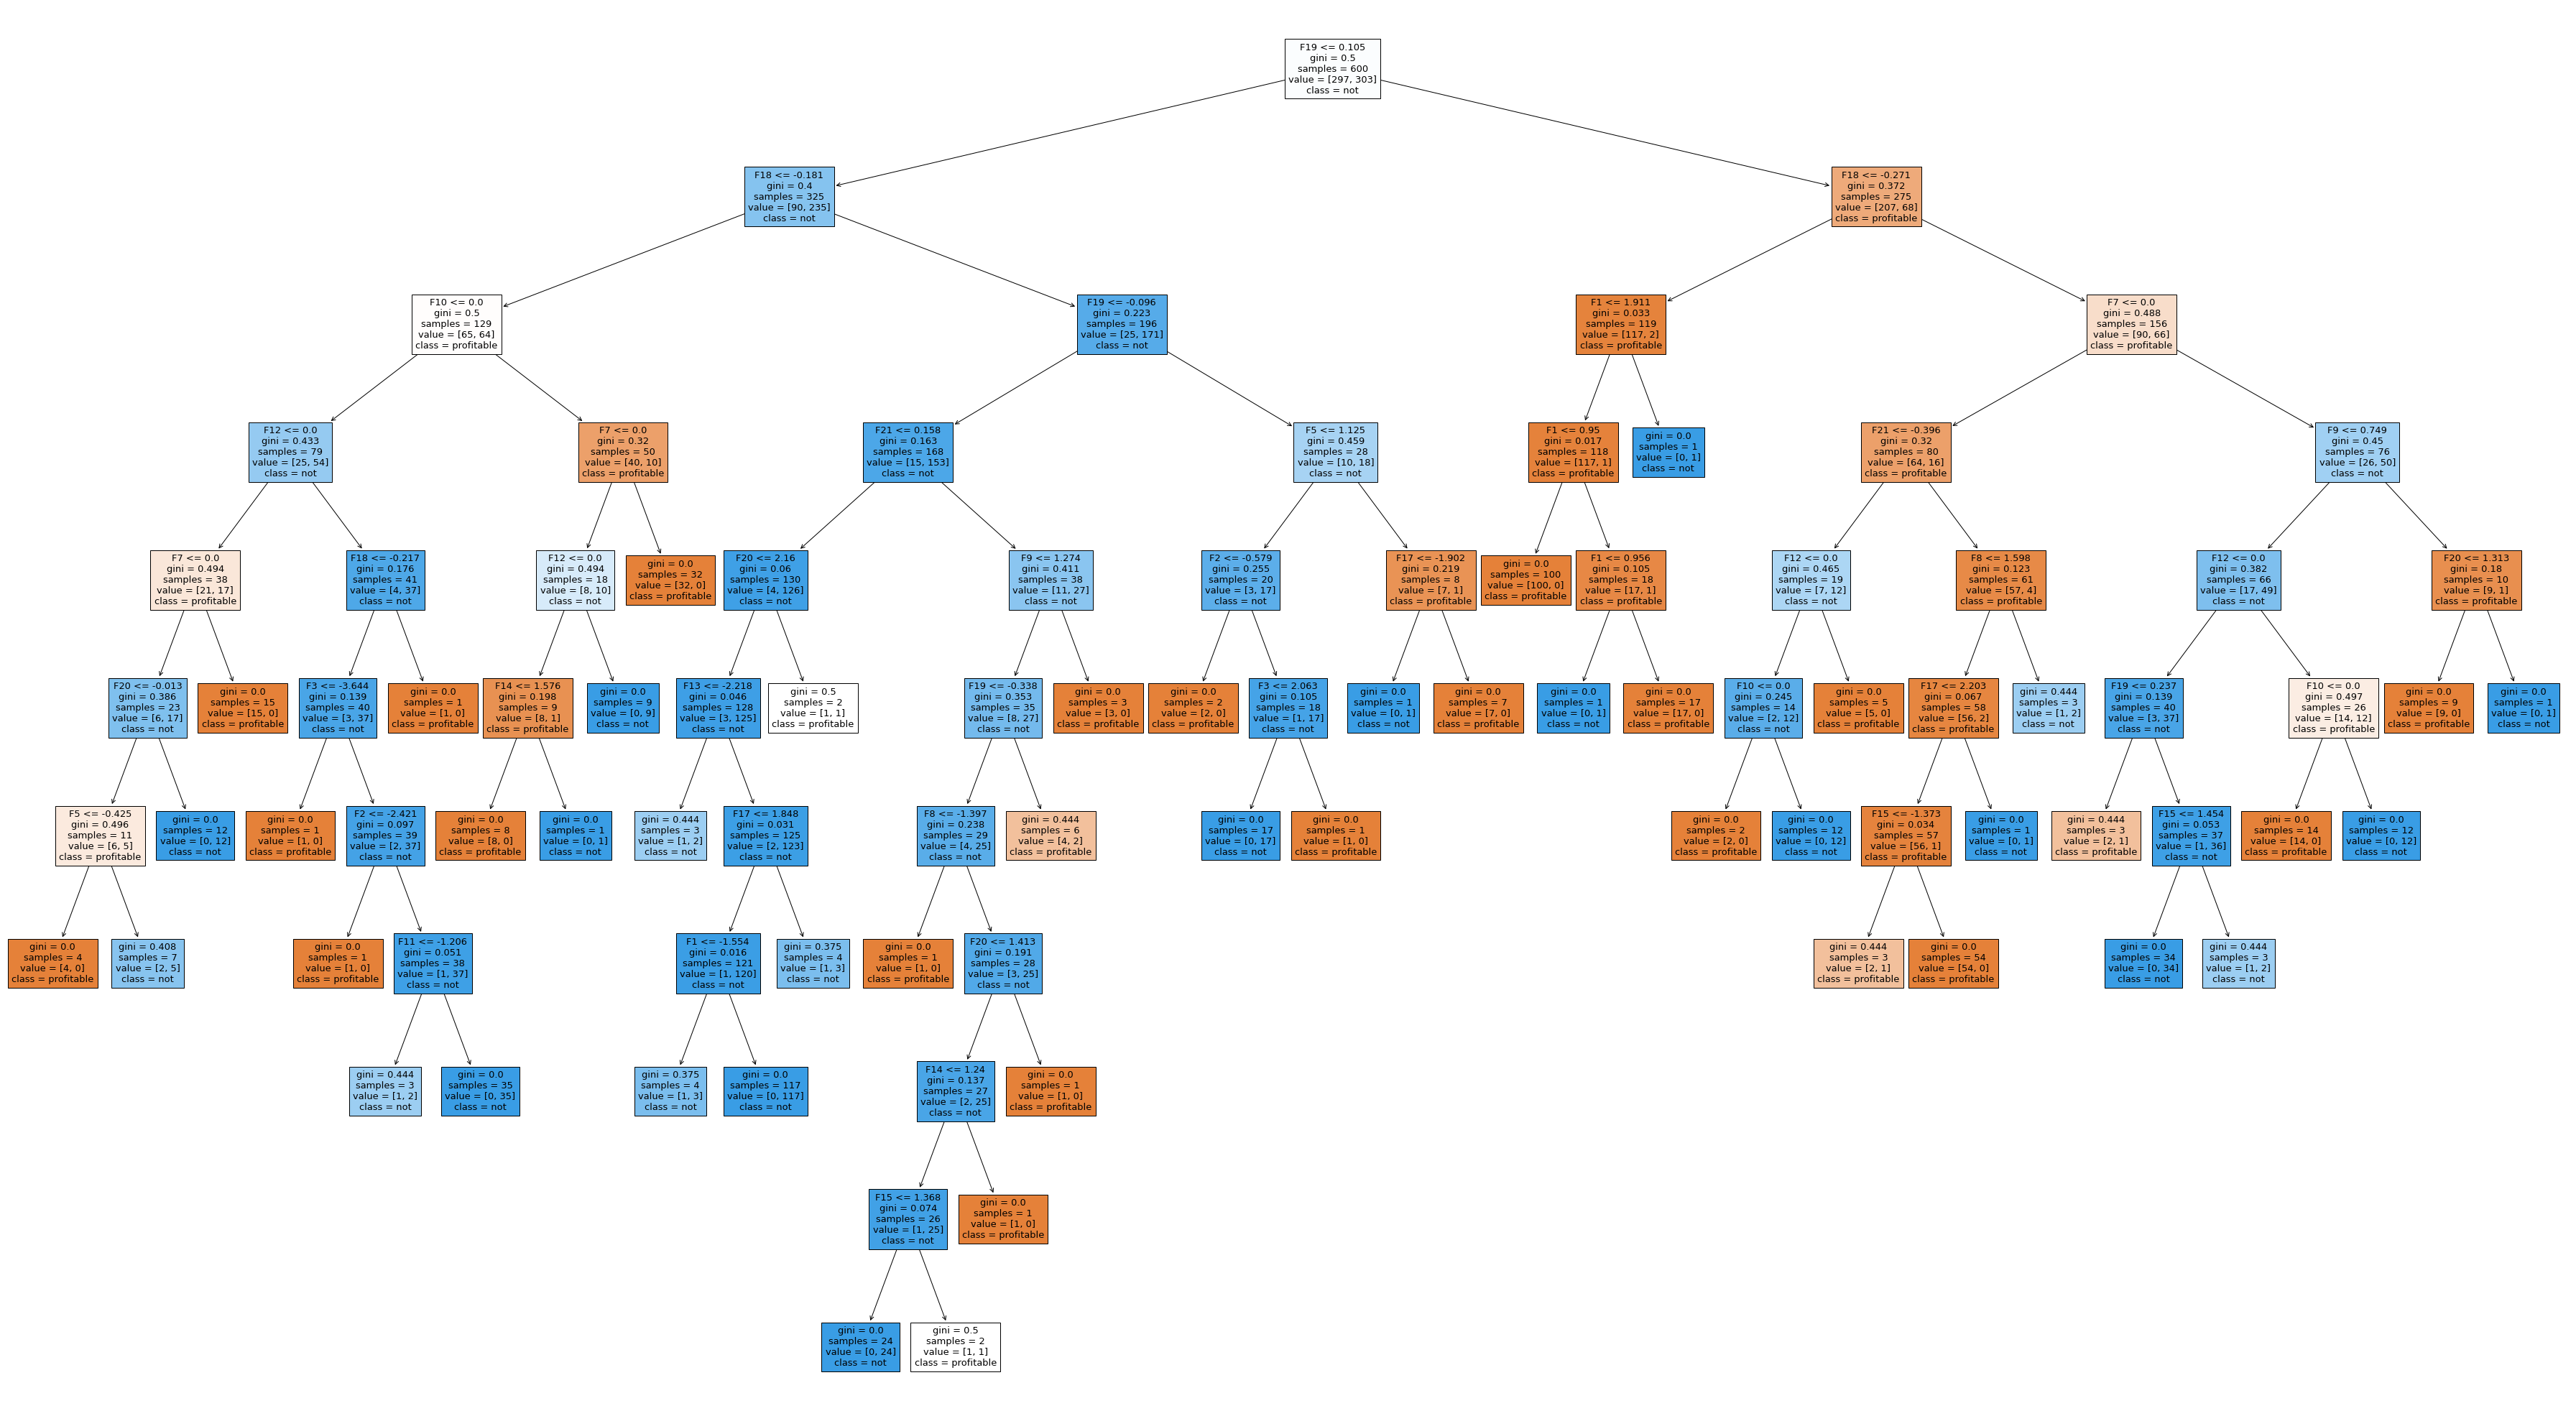

In [22]:
tree_plotter: plt.Figure = plt.figure(figsize=(64,36))

skl.tree.plot_tree(
    tree_searched.best_estimator_["classifier"],
    feature_names=all_data.columns[:-1],
    class_names=["profitable","not"],
    filled=True
)

tree_plotter.show()
tree_plotter.savefig(
    "part2_tree_diagram.png",
    bbox_inches="tight"
)


# K-Nearest Neighbour

In these few cells of this notebook, I shall attempt to perform K-Nearest Neighbour search.

This effectively attempts to find the 'closest'/most similar existing individuals to an
individual in need of classification, and attempts to classify that new individual
based on them.

Of course, there's the question of what one may consider qualifies as 'similar'.
Instead of trying to get involved in that eternal debate, I am going to get the grid-search
cross validator to take care of that philosophical question for me, by specifying
the various possible measures of similarity in the hyper-parameter grid, and then
getting the gridsearchCV to take care of that question for me.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
knn_weights: List[str] = ["uniform","distance"]
knn_algorithms: List[str] = ["auto","ball_tree","kd_tree"]
knn_metrics: List[str] = ["minkowski","chebyshev","wminkowski"]
knn_p: List[int] = [2, 3, 4]
knn_leaf_size: List[int] = [20, 25, 30, 35, 40]
knn_neighbors: List[int] = [4,5,6,7,8]

knn_param_grid: Dict[str, List[Union[str, int]]] = {
    "classifier__weights": knn_weights,
    "classifier__algorithm": knn_algorithms,
    "classifier__metric": knn_metrics,
    "classifier__p": knn_p,
    "classifier__leaf_size": knn_leaf_size,
    "classifier__n_neighbors": knn_neighbors
}

knn_searchers_dict: Dict[
    HalvingGridSearchCV, Tuple[float, np.ndarray, np.ndarray]
] = nested_h_grid_searcher(
    KNeighborsClassifier(),
    knn_param_grid,
    train_data,
    train_labels,
    train_df
)

knn_searcher: HalvingGridSearchCV = max(
    knn_searchers_dict.keys(), key=lambda k: knn_searchers_dict[k][0]
)

best_knn_search: BestGridSearchDict = {
    "search": knn_searcher,
    "score": knn_searchers_dict[knn_searcher][0],
    "test_data": knn_searchers_dict[knn_searcher][1],
    "train_data": knn_searchers_dict[knn_searcher][2]
}

n_iterations: 4
n_required_iterations: 8
n_possible_iterations: 4
min_resources_: 12
max_resources_: 600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2700
n_resources: 12
Fitting 3 folds for each of 2700 candidates, totalling 8100 fits
----------
iter: 1
n_candidates: 900
n_resources: 36
Fitting 3 folds for each of 900 candidates, totalling 2700 fits
----------
iter: 2
n_candidates: 300
n_resources: 108
Fitting 3 folds for each of 300 candidates, totalling 900 fits
----------
iter: 3
n_candidates: 100
n_resources: 324
Fitting 3 folds for each of 100 candidates, totalling 300 fits
n_iterations: 4
n_required_iterations: 8
n_possible_iterations: 4
min_resources_: 12
max_resources_: 600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2700
n_resources: 12
Fitting 3 folds for each of 2700 candidates, totalling 8100 fits
----------
iter: 1
n_candidates: 900
n_resources: 36
Fitting 3 folds for each of 900 candidates, totalling 2700 fits
----

In [25]:
print(best_knn_search)


{'search': HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    error_score=0,
                    estimator=Pipeline(steps=[('scaler',
                                               QuantileTransformer(output_distribution='normal')),
                                              ('imputer',
                                               KNNImputer(add_indicator=True)),
                                              ('classifier',
                                               KNeighborsClassifier())]),
                    n_jobs=-1,
                    param_grid={'classifier__algorithm': ['auto', 'ball_tree',
                                                          'kd_tree'],
                                'classifier__leaf_size': [20, 25, 30, 35, 40],
                                'classifier__metric': ['minkowski', 'chebyshev',
                                                       'wminkowski'],
                             

In [26]:
print(best_knn_search["score"])
print(knn_searcher.best_params_)

knn_searcher.best_estimator_

0.6959669361431556
{'classifier__algorithm': 'kd_tree', 'classifier__leaf_size': 40, 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 8, 'classifier__p': 2, 'classifier__weights': 'distance', 'imputer__weights': 'distance'}


Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(add_indicator=True, weights='distance')),
                ('classifier',
                 KNeighborsClassifier(algorithm='kd_tree', leaf_size=40,
                                      n_neighbors=8, weights='distance'))])

# Support Vector Machine Classifier

And here I am attempting to create a support vector machine classifier for the data.
Of course, there are multiple options for kernels, coeffecients for aforementioned kernels,
regularization, degrees for the polynomial kernel, secondary coefficients for certain kernels,
etc.

In [27]:
from sklearn.svm import SVC

In [28]:
svc_c: np.ndarray = np.linspace(0, 2, 21)
svc_kernel: List[str] = ["poly","rbf","sigmoid"]
svc_degree: List[int] = [2,3,4]
# degree is only relevant for the poly(nomial) kernel.
# unfortunately, it doesn't look like there's a way for this to be applied only to the polynomial kernel,
# so there is going to be a lot of wasted computation on trying different degrees for rbf and sigmoid.
svc_gamma: List[str] = ["scale","auto"]
svc_coef0: np.ndarray = np.linspace(-0.2, 0.2, 6)
svc_class_weight = ["balanced",None]

svc_param_grid: Dict[str, Any] = {
    "classifier__C": svc_c,
    "classifier__kernel": svc_kernel,
    "classifier__degree": svc_degree,
    "classifier__gamma": svc_gamma,
    "classifier__coef0": svc_coef0,
    "classifier__class_weight": svc_class_weight
}

svc_searchers_dict: Dict[
    HalvingGridSearchCV, Tuple[float, np.ndarray, np.ndarray]
] = nested_h_grid_searcher(
    SVC(),
    svc_param_grid,
    train_data,
    train_labels,
    train_df
)

svc_searcher: HalvingGridSearchCV = max(
    svc_searchers_dict.keys(), key=lambda k: svc_searchers_dict[k][0]
)

best_svc_search: BestGridSearchDict = {
    "search": svc_searcher,
    "score": svc_searchers_dict[svc_searcher][0],
    "test_data": svc_searchers_dict[svc_searcher][1],
    "train_data": svc_searchers_dict[svc_searcher][2]
}

n_iterations: 4
n_required_iterations: 9
n_possible_iterations: 4
min_resources_: 12
max_resources_: 600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9072
n_resources: 12
Fitting 3 folds for each of 9072 candidates, totalling 27216 fits
----------
iter: 1
n_candidates: 3024
n_resources: 36
Fitting 3 folds for each of 3024 candidates, totalling 9072 fits
----------
iter: 2
n_candidates: 1008
n_resources: 108
Fitting 3 folds for each of 1008 candidates, totalling 3024 fits
----------
iter: 3
n_candidates: 336
n_resources: 324
Fitting 3 folds for each of 336 candidates, totalling 1008 fits
n_iterations: 4
n_required_iterations: 9
n_possible_iterations: 4
min_resources_: 12
max_resources_: 600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9072
n_resources: 12
Fitting 3 folds for each of 9072 candidates, totalling 27216 fits
----------
iter: 1
n_candidates: 3024
n_resources: 36
Fitting 3 folds for each of 3024 candidates, totalling 9072

In [29]:
print(best_svc_search)

{'search': HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                    error_score=0,
                    estimator=Pipeline(steps=[('scaler',
                                               QuantileTransformer(output_distribution='normal')),
                                              ('imputer',
                                               KNNImputer(add_indicator=True)),
                                              ('classifier', SVC())]),
                    n_jobs=-1,
                    param_grid={'classifier__C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1...
                                'classifier__class_weight': ['balanced', None],
                                'classifier__coef0': array([-0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ]),
                                'classifier__degree': [2, 3, 4],
                                'classifier__gamma': ['scale', 'auto'],
             

In [30]:
print(best_svc_search["score"])
print(svc_searcher.best_params_)

svc_searcher.best_estimator_



0.780105089456314
{'classifier__C': 1.0, 'classifier__class_weight': None, 'classifier__coef0': 0.2, 'classifier__degree': 4, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly', 'imputer__weights': 'distance'}


Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('imputer', KNNImputer(add_indicator=True, weights='distance')),
                ('classifier', SVC(coef0=0.2, degree=4, kernel='poly'))])

## Using my held-out test set on each of the 'best' classifiers I found, in an attempt to find the best one

Along with graphs of the confusion matrices, 'true positive/false positive' curves,
as well as the sensitivity/specificity curves.

This is mostly to give a decent overview of each classifier compared to each other.

In [43]:
tests: Tuple[np.ndarray, np.ndarray] = np_data_and_classes(validation_df)
test_data: np.ndarray = tests[0]
test_labels: np.ndarray = tests[1]

print(len(test_data))
print(len(test_labels))

200
200


In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

def plot_confusion_matrix_and_tf_pos_rates_and_precision_recall(
        predicted_labels: np.ndarray,
        actual_labels: np.ndarray,
        decision_score: np.ndarray,
        model_name: str
) -> plt.Figure:

    figaxes: Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes, plt.Axes]] = plt.subplots(
        1,3, figsize=(32,18)
    )

    fig: plt.Figure = figaxes[0]

    fig.suptitle("Confusion matrix, ROC curve, and precision/recall info for " + model_name)

    ax1: plt.Axes = figaxes[1][0]
    ax2: plt.Axes = figaxes[1][1]
    ax3: plt.Axes = figaxes[1][2]

    cm = confusion_matrix(actual_labels, predicted_labels)

    ConfusionMatrixDisplay(cm).plot(ax=ax1)
    ax1.set_title("Confusion matrix")

    fpr, tpr, _ = roc_curve(actual_labels, decision_score, pos_label=True)

    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax2)
    ax2.set_title("True/False positive rate")

    prec, recall, _ = precision_recall_curve(actual_labels, decision_score, pos_label=True)
    PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
    ax3.set_title("Precision/recall")

    return fig




In [33]:
dt_labels = tree_searched.predict(test_data)
dt_y_score = tree_searched.predict_proba(test_data)[:,1]
dt_score: float = tree_searched.score(test_data, test_labels)
print(dt_score)

0.8031594906003638


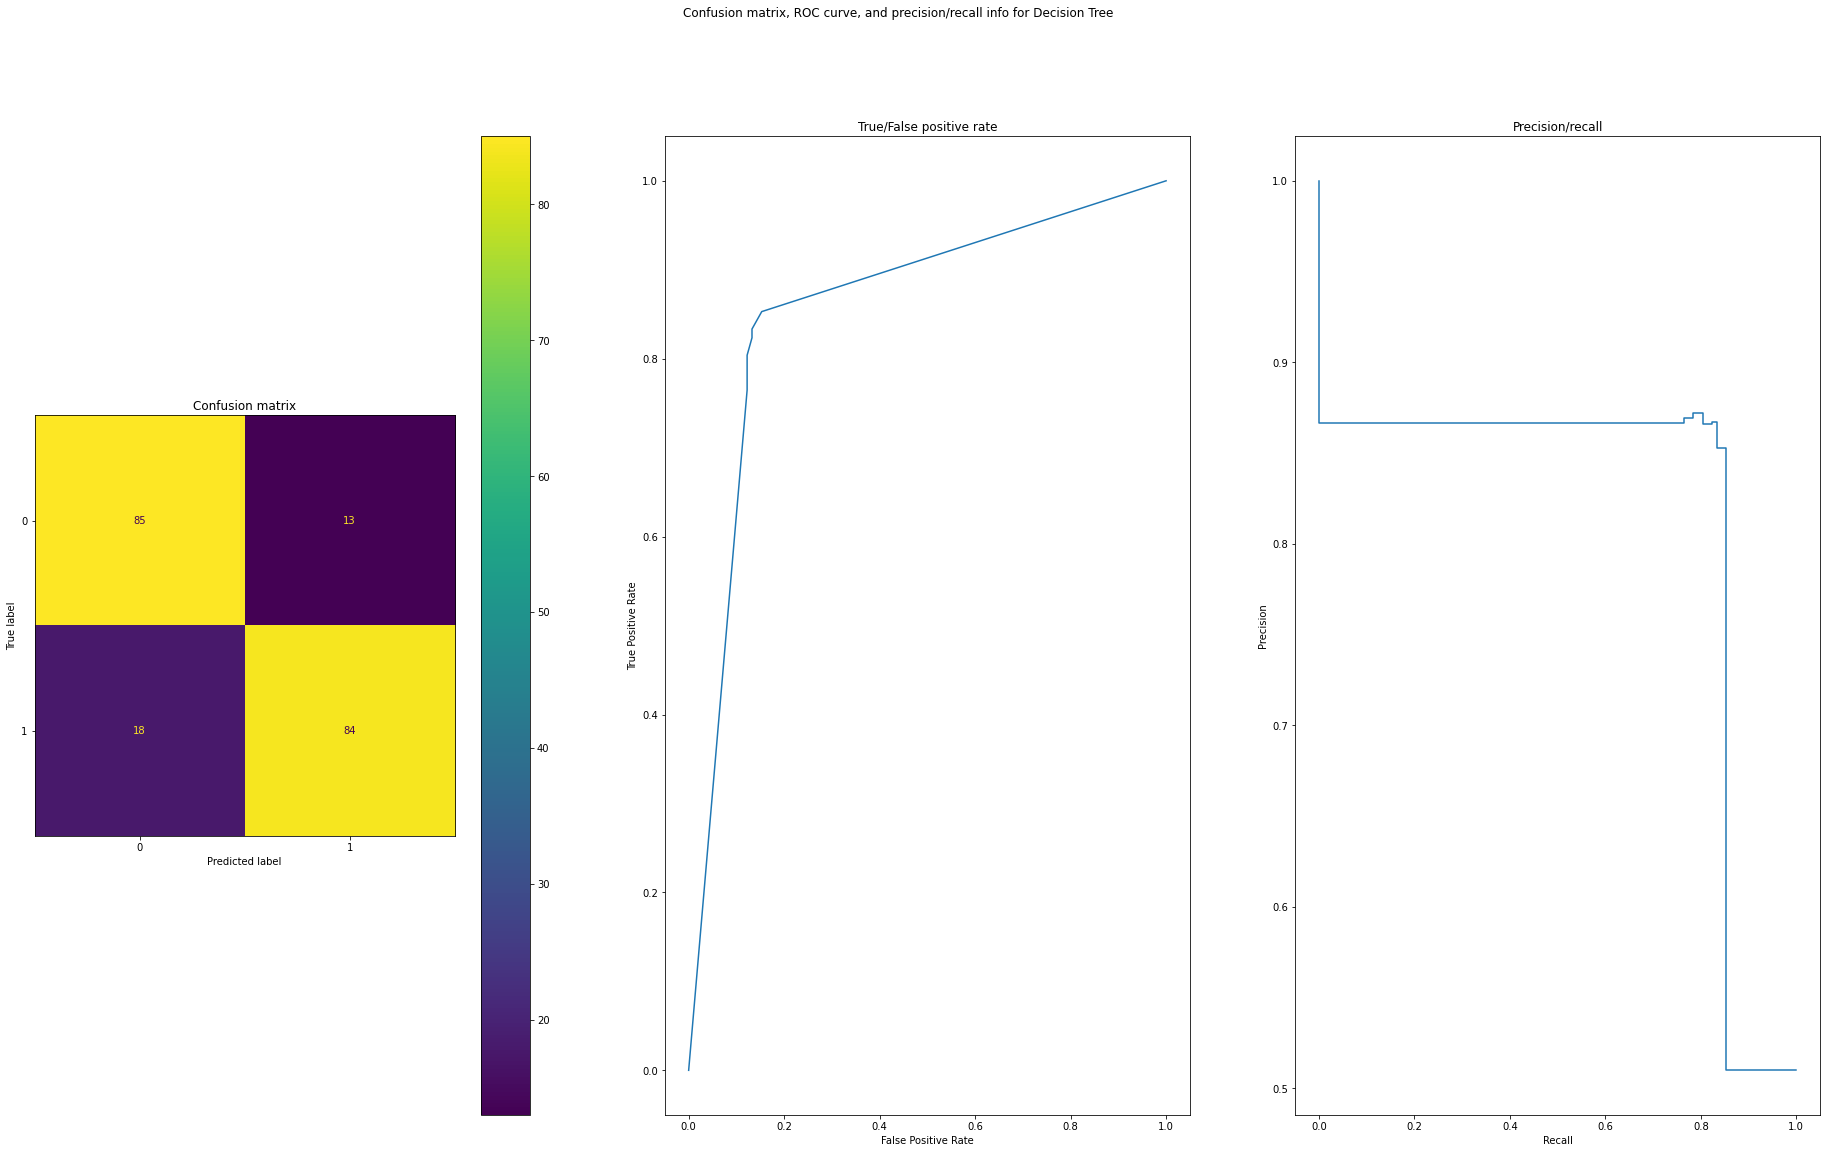

In [34]:
dt_fig: plt.Figure = plot_confusion_matrix_and_tf_pos_rates_and_precision_recall(
    dt_labels,
    test_labels,
    dt_y_score,
    "Decision Tree"
)

dt_fig.show()
dt_fig.savefig(
    "part2_dt_stats.png",
    bbox_inches="tight"
)

In [35]:
knn_labels = knn_searcher.predict(test_data)
knn_y_score = knn_searcher.predict_proba(test_data)[:,1]
knn_score: float = knn_searcher.score(test_data, test_labels)
print(knn_score)

0.664221235664077


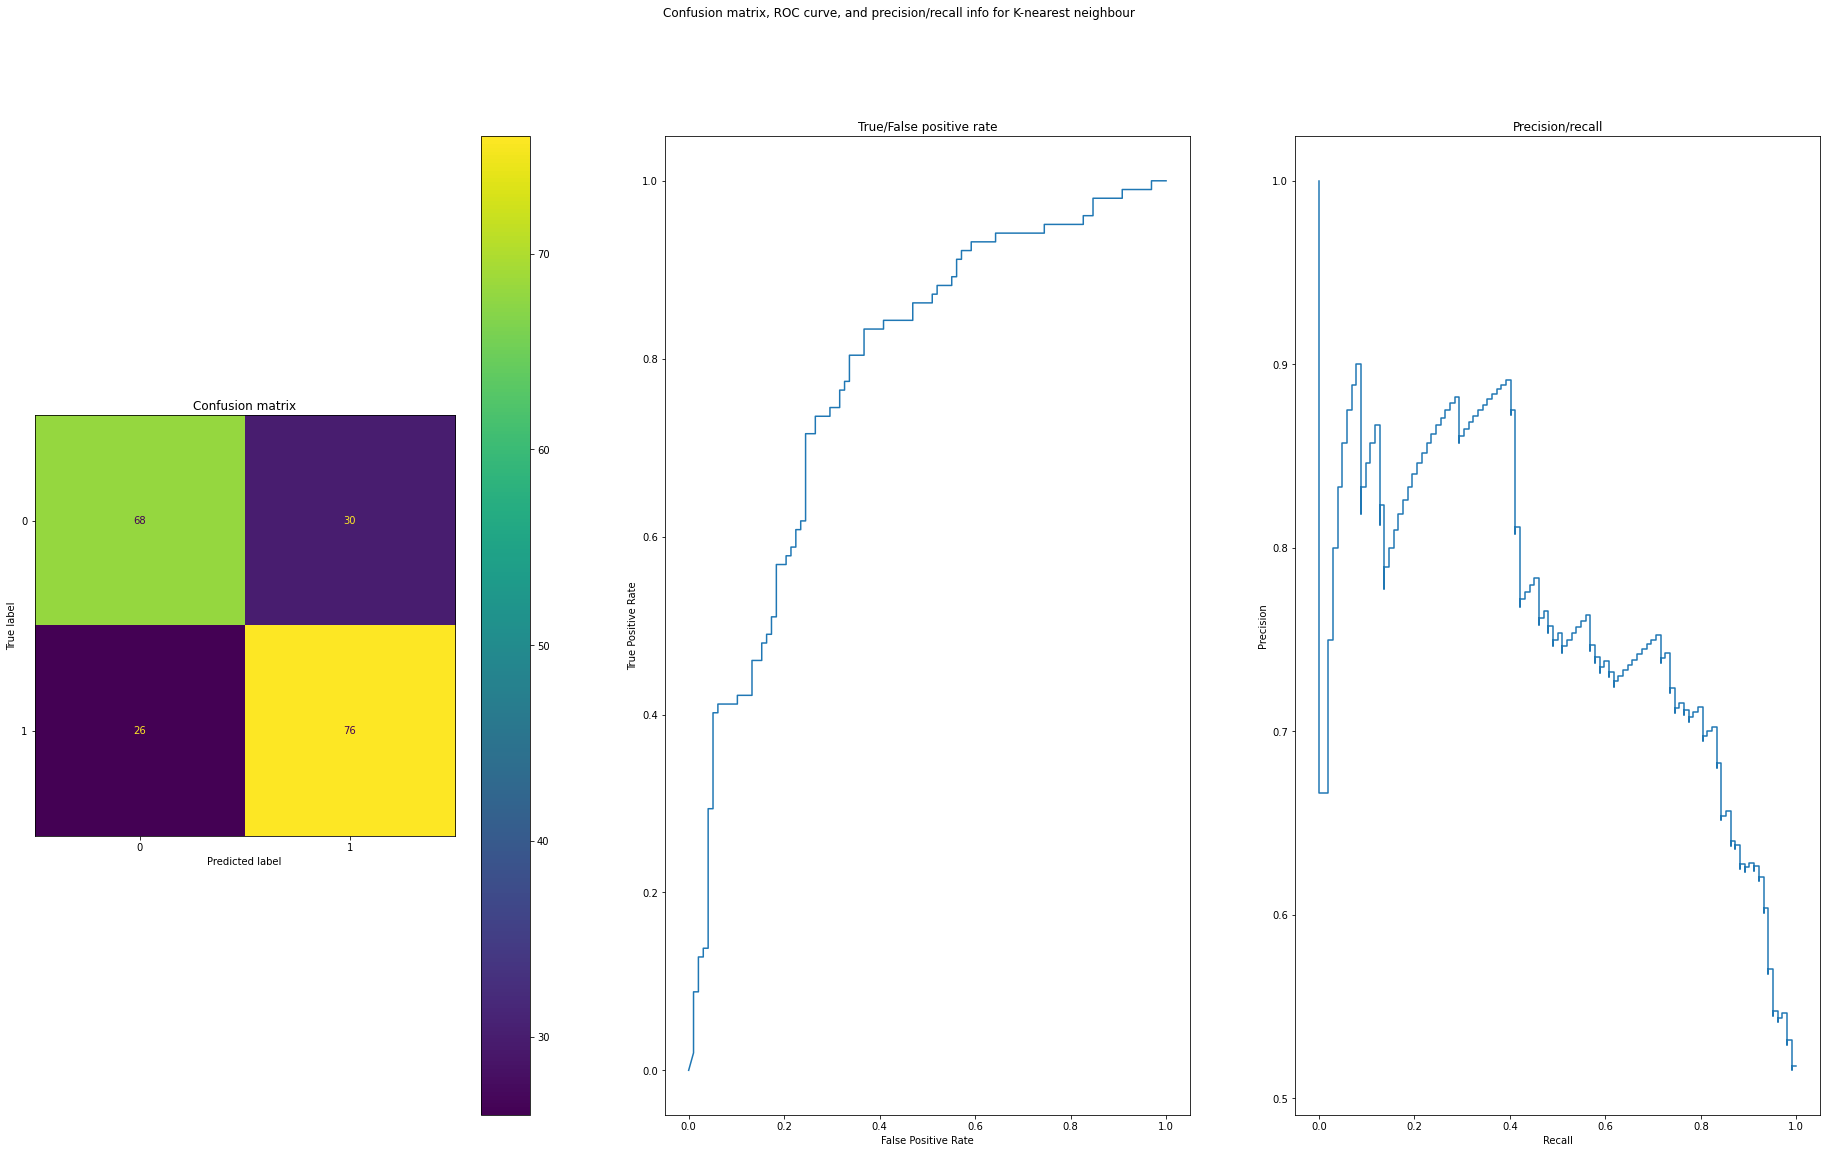

In [36]:
knn_fig: plt.Figure = plot_confusion_matrix_and_tf_pos_rates_and_precision_recall(
    knn_labels,
    test_labels,
    knn_y_score,
    "K-nearest neighbour"
)

knn_fig.show()
knn_fig.savefig(
    "part2_knn_stats.png",
    bbox_inches="tight"
)

In [44]:
svc_labels = svc_searcher.predict(test_data)
svc_y_score = svc_searcher.decision_function(test_data)
svc_score: float = svc_searcher.score(test_data, test_labels)
print(svc_score)

0.7244962812711291


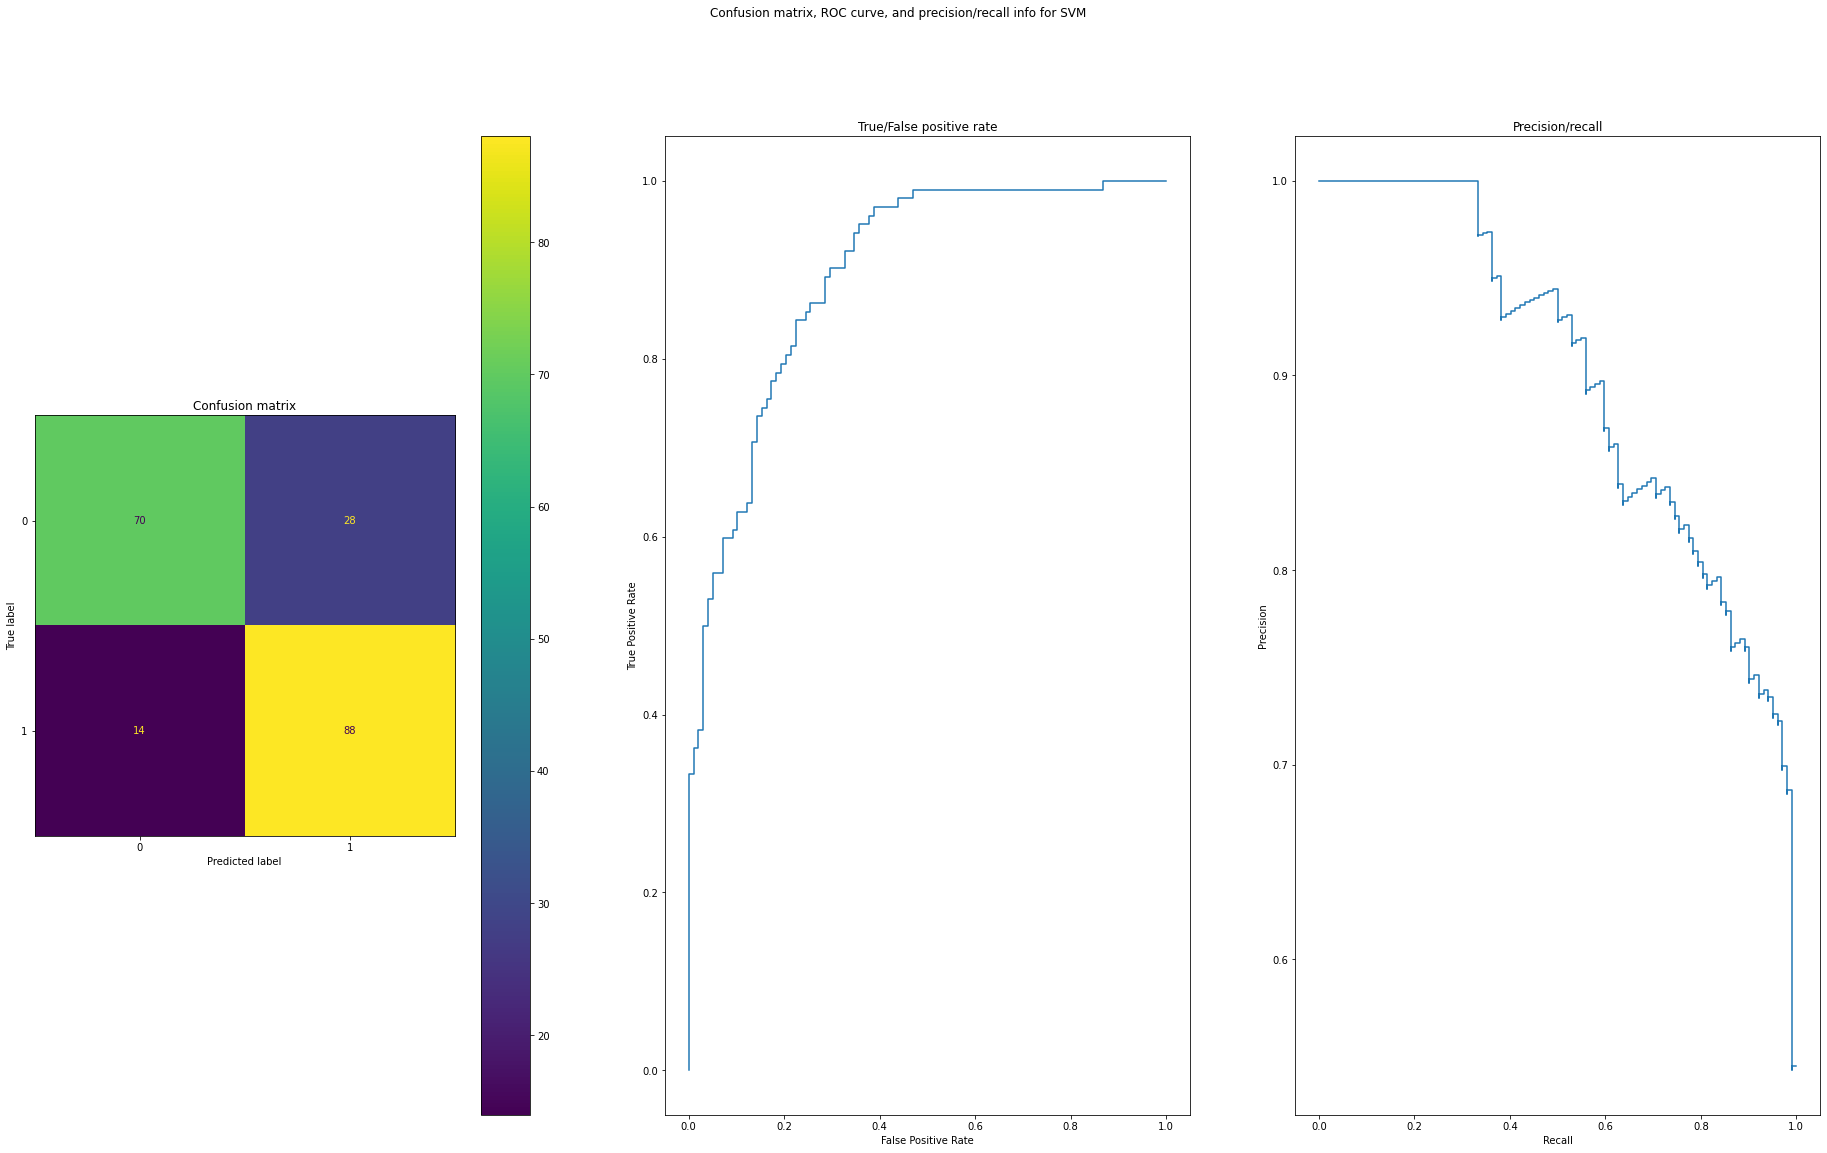

In [38]:
svm_fig: plt.Figure = plot_confusion_matrix_and_tf_pos_rates_and_precision_recall(
    svc_labels,
    test_labels,
    svc_y_score,
    "SVM"
)

svm_fig.show()
svm_fig.savefig(
    "part2_svm_stats.png",
    bbox_inches="tight"
)

In [39]:
all_classifiers: List[Tuple[str,BestGridSearchDict, float]] = [
    ("dt", best_tree_search, dt_score),
    ("knn", best_knn_search, knn_score),
    ("svm", best_svc_search, svc_score)
]

best_classifier: Tuple[str, BestGridSearchDict, float] = max(
    all_classifiers, key=lambda t: t[2]
)

In [40]:
print("THE BEST CLASSIFIER IS...")
print(best_classifier[0])

print(f"with an overall score on the test data of {best_classifier[2]}")

THE BEST CLASSIFIER IS...
dt
with an overall score on the test data of 0.8031594906003638


Welp, with an overall score of `0.8031594906003638` on my held-out test data, it appears that the
decision tree is ultimately the best model for the job, beating the
SVM-based classifier and the KNN-based classifier.

The KNN-based classifier performed rather poorly overall, only achieving a score of `0.664221235664077`.
The SVM-based classifier performed slightly better, with a score of

### Part B

And now it's time for some predictions that may or may not be entirely incorrect!

In [41]:
# HERE YOU WILL USE THIS TEMPLATE TO SAVE THE PREDICTIONS ON THE TEST SET

# Load the test data
test_df = pd.read_csv('CE802_P2_Test.csv')

# Make sure you work on a copy
test_data: pd.DataFrame = test_df.iloc[:,:-1].copy()

test_data_np: np.ndarray = test_data.to_numpy()

predicted = best_classifier[1]["search"].predict(test_data_np)

#predicted = ... # CHANGE HERE -- use your previously trained predictor and apply it to test_data
                # (test_data can be modified if needed but make sure you don't change the order of the rows)...

# Replace the last (empty) column with your prediction
test_df.iloc[:,-1] = predicted

# Save to the destination file
test_df.to_csv('CE802_P2_Test_Predictions.csv', index=False, float_format='%.8g')

# IMPORTANT!! Make sure only the last column has changed
assert pd.read_csv('CE802_P2_Test.csv').iloc[:,:-1].equals(pd.read_csv('CE802_P2_Test_Predictions.csv').iloc[:,:-1])